<a href="https://colab.research.google.com/github/Aakriti555/Nammi-task3/blob/main/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align: center;">Task 3: Feature Extraction and Comparison</h1>


**Overview**: Build pipeline for feature extraction and comparison from knee CT scan. Use the CT scan file
provided in Task 1 for this exercise.


# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import label, binary_fill_holes
import torch.nn.functional as F
import pandas as pd
import os
from collections import OrderedDict

In [2]:
# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Loading the data

In [3]:
file_path = '/content/3702_left_knee.nii.gz'

In [4]:
# Load the NIfTI file
img = nib.load(file_path)
img_data = img.get_fdata()

print(f"Loaded CT Scan. Shape: {img_data.shape}")

Loaded CT Scan. Shape: (512, 512, 216)


# 1. Segmentation-Based Splitting

In [5]:
# Apply a threshold to segment high-intensity regions (bones)
threshold = 350
bone_mask = img_data > threshold

# Label connected components in the binary mask
labeled_array, num_features = label(bone_mask)
print(f"Found {num_features} connected components after thresholding.")

# Identify the two largest components as Femur and Tibia
if num_features < 2:
    print("Error: Could not find at least two distinct bone components. Try adjusting the threshold.")
    exit()

component_sizes = [(labeled_array == i).sum() for i in range(1, num_features + 1)]
sorted_indices = np.argsort(component_sizes)[::-1]  # Sort in descending order

# Assign the largest component to Femur and the second largest to Tibia
femur_label = sorted_indices[0] + 1
tibia_label = sorted_indices[1] + 1
femur_mask = (labeled_array == femur_label)
tibia_mask = (labeled_array == tibia_label)

# The given image shows Femur as the upper bone. Let's verify by centroid.
# The z-axis (axis 2) typically represents the superior-inferior direction.
femur_centroid_z = np.mean(np.argwhere(femur_mask)[:, 2])
tibia_centroid_z = np.mean(np.argwhere(tibia_mask)[:, 2])

if femur_centroid_z < tibia_centroid_z:
    # The component we labeled Femur is inferior to the Tibia, so they are swapped.
    print("Swapping Femur and Tibia masks based on z-axis centroid.")
    femur_mask, tibia_mask = tibia_mask, femur_mask

# Create the background mask (non-femur and non-tibia)
background_mask = ~ (femur_mask | tibia_mask)

print("Successfully created masks for Femur, Tibia, and Background.")

Found 511 connected components after thresholding.
Successfully created masks for Femur, Tibia, and Background.


## Visualisation of regions

- Tibia region (green)
- Femur region (red)
- Background / non-bone region

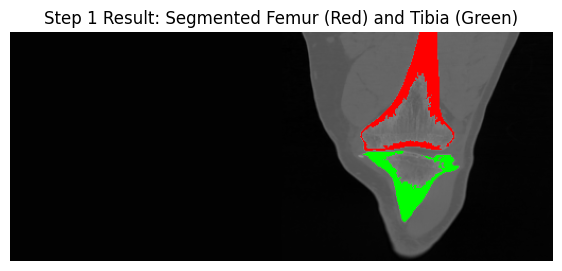

In [6]:
# Visualize the segmentation on a central slice
slice_index = img_data.shape[1] // 2
base_slice = img_data[:, slice_index, :]
femur_slice = femur_mask[:, slice_index, :]
tibia_slice = tibia_mask[:, slice_index, :]

base_norm = (base_slice - np.min(base_slice)) / (np.max(base_slice) - np.min(base_slice))
base_rgb = np.stack([base_norm] * 3, axis=-1)
base_rgb[femur_slice] = [1.0, 0.0, 0.0]  # Red for Femur
base_rgb[tibia_slice] = [0.0, 1.0, 0.0]  # Green for Tibia
plt.figure(figsize=(7, 7))
plt.imshow(np.transpose(base_rgb, (1, 0, 2)), origin='lower')
plt.title('Step 1 Result: Segmented Femur (Red) and Tibia (Green)')
plt.axis('off')
plt.show()


# 2. Convert 2D Pretrained Model to 3D:

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
import copy

def inflate_conv2d_to_conv3d(conv2d_layer, depth=16):
    """
    Convert a Conv2d layer to Conv3d by inflating weights along depth dimension

    Args:
        conv2d_layer: nn.Conv2d layer to convert
        depth: depth dimension for the 3D convolution

    Returns:
        nn.Conv3d layer with inflated weights
    """
    # Get parameters from 2D layer
    in_channels = conv2d_layer.in_channels
    out_channels = conv2d_layer.out_channels
    kernel_size_2d = conv2d_layer.kernel_size
    stride_2d = conv2d_layer.stride
    padding_2d = conv2d_layer.padding
    dilation_2d = conv2d_layer.dilation
    groups = conv2d_layer.groups
    bias = conv2d_layer.bias is not None

    # Convert 2D parameters to 3D
    if isinstance(kernel_size_2d, int):
        kernel_size_3d = (3, kernel_size_2d, kernel_size_2d)  # Default depth kernel = 3
    else:
        kernel_size_3d = (3, kernel_size_2d[0], kernel_size_2d[1])

    if isinstance(stride_2d, int):
        stride_3d = (1, stride_2d, stride_2d)  # No stride along depth
    else:
        stride_3d = (1, stride_2d[0], stride_2d[1])

    if isinstance(padding_2d, int):
        padding_3d = (1, padding_2d, padding_2d)  # Padding of 1 along depth
    else:
        padding_3d = (1, padding_2d[0], padding_2d[1])

    if isinstance(dilation_2d, int):
        dilation_3d = (1, dilation_2d, dilation_2d)  # No dilation along depth
    else:
        dilation_3d = (1, dilation_2d[0], dilation_2d[1])

    # Create 3D convolution layer
    conv3d_layer = nn.Conv3d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=kernel_size_3d,
        stride=stride_3d,
        padding=padding_3d,
        dilation=dilation_3d,
        groups=groups,
        bias=bias
    )

    # Inflate 2D weights to 3D
    with torch.no_grad():
        # Get 2D weights: (out_channels, in_channels, height, width)
        weights_2d = conv2d_layer.weight.data

        # Repeat along new depth dimension and normalize
        # Shape becomes: (out_channels, in_channels, depth, height, width)
        depth_kernel = kernel_size_3d[0]
        weights_3d = weights_2d.unsqueeze(2).repeat(1, 1, depth_kernel, 1, 1)

        # Normalize by depth to maintain consistent scaling
        weights_3d = weights_3d / depth_kernel

        # Assign inflated weights
        conv3d_layer.weight.data = weights_3d

        # Copy bias if it exists
        if bias:
            conv3d_layer.bias.data = conv2d_layer.bias.data.clone()

    return conv3d_layer

def inflate_batchnorm2d_to_batchnorm3d(bn2d_layer):
    """
    Convert BatchNorm2d to BatchNorm3d (parameters remain the same)
    """
    bn3d_layer = nn.BatchNorm3d(
        num_features=bn2d_layer.num_features,
        eps=bn2d_layer.eps,
        momentum=bn2d_layer.momentum,
        affine=bn2d_layer.affine,
        track_running_stats=bn2d_layer.track_running_stats
    )

    # Copy parameters
    with torch.no_grad():
        if bn2d_layer.affine:
            bn3d_layer.weight.data = bn2d_layer.weight.data.clone()
            bn3d_layer.bias.data = bn2d_layer.bias.data.clone()
        if bn2d_layer.track_running_stats:
            bn3d_layer.running_mean.data = bn2d_layer.running_mean.data.clone()
            bn3d_layer.running_var.data = bn2d_layer.running_var.data.clone()
            bn3d_layer.num_batches_tracked.data = bn2d_layer.num_batches_tracked.data.clone()

    return bn3d_layer

def convert_layer_2d_to_3d(layer):
    """
    Recursively convert layers from 2D to 3D
    """
    if isinstance(layer, nn.Conv2d):
        return inflate_conv2d_to_conv3d(layer)
    elif isinstance(layer, nn.BatchNorm2d):
        return inflate_batchnorm2d_to_batchnorm3d(layer)
    elif isinstance(layer, nn.AdaptiveAvgPool2d):
        # Convert 2D adaptive pooling to 3D
        output_size = layer.output_size
        if isinstance(output_size, int):
            output_size_3d = (1, output_size, output_size)
        else:
            output_size_3d = (1, output_size[0], output_size[1])
        return nn.AdaptiveAvgPool3d(output_size_3d)
    elif isinstance(layer, nn.AvgPool2d):
        # Convert 2D average pooling to 3D
        kernel_size = layer.kernel_size
        stride = layer.stride
        padding = layer.padding
        ceil_mode = layer.ceil_mode
        count_include_pad = layer.count_include_pad

        if isinstance(kernel_size, int):
            kernel_size_3d = (1, kernel_size, kernel_size)
        else:
            kernel_size_3d = (1, kernel_size[0], kernel_size[1])

        if stride is None:
            stride_3d = None
        elif isinstance(stride, int):
            stride_3d = (1, stride, stride)
        else:
            stride_3d = (1, stride[0], stride[1])

        if isinstance(padding, int):
            padding_3d = (0, padding, padding)
        else:
            padding_3d = (0, padding[0], padding[1])

        return nn.AvgPool3d(
            kernel_size=kernel_size_3d,
            stride=stride_3d,
            padding=padding_3d,
            ceil_mode=ceil_mode,
            count_include_pad=count_include_pad
        )
    elif isinstance(layer, nn.MaxPool2d):
        # Convert 2D max pooling to 3D
        kernel_size = layer.kernel_size
        stride = layer.stride
        padding = layer.padding
        dilation = layer.dilation
        return_indices = layer.return_indices
        ceil_mode = layer.ceil_mode

        if isinstance(kernel_size, int):
            kernel_size_3d = (1, kernel_size, kernel_size)
        else:
            kernel_size_3d = (1, kernel_size[0], kernel_size[1])

        if stride is None:
            stride_3d = None
        elif isinstance(stride, int):
            stride_3d = (1, stride, stride)
        else:
            stride_3d = (1, stride[0], stride[1])

        if isinstance(padding, int):
            padding_3d = (0, padding, padding)
        else:
            padding_3d = (0, padding[0], padding[1])

        if isinstance(dilation, int):
            dilation_3d = (1, dilation, dilation)
        else:
            dilation_3d = (1, dilation[0], dilation[1])

        return nn.MaxPool3d(
            kernel_size=kernel_size_3d,
            stride=stride_3d,
            padding=padding_3d,
            dilation=dilation_3d,
            return_indices=return_indices,
            ceil_mode=ceil_mode
        )
    elif hasattr(layer, 'children') and len(list(layer.children())) > 0:
        # Recursively convert child layers
        new_layer = copy.deepcopy(layer)
        for name, child in layer.named_children():
            setattr(new_layer, name, convert_layer_2d_to_3d(child))
        return new_layer
    else:
        # Return layer as-is if no conversion needed
        return copy.deepcopy(layer)

def convert_densenet121_2d_to_3d():
    """
    Convert a pretrained 2D DenseNet121 to 3D
    """
    print("Loading pretrained DenseNet121...")
    # Use the new weights parameter instead of pretrained
    model_2d = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

    print("Converting 2D layers to 3D...")

    # Create a new DenseNet-like structure for 3D
    class DenseNet3D(nn.Module):
        def __init__(self, features, classifier):
            super(DenseNet3D, self).__init__()
            self.features = features
            self.classifier = classifier

        def forward(self, x):
            features = self.features(x)
            out = nn.functional.relu(features, inplace=True)
            out = nn.functional.adaptive_avg_pool3d(out, (1, 1, 1))
            out = torch.flatten(out, 1)
            out = self.classifier(out)
            return out

    # Convert features (convolutional layers)
    features_3d = convert_layer_2d_to_3d(model_2d.features)

    # Keep classifier the same (it's just Linear layers)
    classifier_3d = copy.deepcopy(model_2d.classifier)

    # Create the 3D model
    model_3d = DenseNet3D(features_3d, classifier_3d)

    return model_3d

def test_conversion():
    """
    Test the 2D to 3D conversion
    """
    print("="*50)
    print("Testing 2D to 3D DenseNet121 Conversion")
    print("="*50)

    # Convert model
    model_3d = convert_densenet121_2d_to_3d()

    # Test with dummy input
    batch_size = 2
    channels = 3
    depth = 16
    height = 224
    width = 224

    dummy_input = torch.randn(batch_size, channels, depth, height, width)

    print(f"Input shape: {dummy_input.shape}")

    # Set model to evaluation mode
    model_3d.eval()

    with torch.no_grad():
        output = model_3d(dummy_input)
        print(f"Output shape: {output.shape}")
        print(f"Output (first 5 values): {output[0, :5].tolist()}")

    # Print model summary
    print("\nModel conversion completed successfully!")
    print(f"Number of parameters: {sum(p.numel() for p in model_3d.parameters()):,}")

    return model_3d

if __name__ == "__main__":
    # Run the conversion and test
    model_3d = test_conversion()

    # Example of how to access converted layers
    print("\nExample: Checking first conv layer conversion")
    first_conv = model_3d.features.conv0
    print(f"First conv layer: {first_conv}")
    print(f"Weight shape: {first_conv.weight.shape}")
    print(f"Kernel size: {first_conv.kernel_size}")
    print(f"Stride: {first_conv.stride}")
    print(f"Padding: {first_conv.padding}")

Testing 2D to 3D DenseNet121 Conversion
Loading pretrained DenseNet121...


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 109MB/s] 


Converting 2D layers to 3D...
Input shape: torch.Size([2, 3, 16, 224, 224])
Output shape: torch.Size([2, 1000])
Output (first 5 values): [-0.2688390910625458, 0.30544012784957886, 1.272519588470459, -0.21241387724876404, 1.5863898992538452]

Model conversion completed successfully!
Number of parameters: 21,719,272

Example: Checking first conv layer conversion
First conv layer: Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
Weight shape: torch.Size([64, 3, 3, 7, 7])
Kernel size: (3, 7, 7)
Stride: (1, 2, 2)
Padding: (1, 3, 3)


# 3. Feature Extraction

## Inference

In [8]:
# extracting 3D CNN features for each input 3D volume and region.
# run the model for each input.


## Feature maps from Last convolution layer

### Visualisation

## Feature maps from third-Last convolution layer

### Visualisation

## Feature maps from fifth-last convolution layer

### Visualisation

## Global average pooling

In [9]:
# Apply global average pooling (GAP) to each extracted feature map to produce a
# fixed N-dimensional feature vector



# 4. Feature Comparison

# 5. Results Organisation